# Chasing ghosts in triathlon data: rule-based anomaly detection

This notebook accompanies a planned Medium article on anomaly detection in Ironman and 70.3 race results.

The goal is to identify suspicious or implausible race results using simple, transparent rules:

- Hard limits on physically plausible speeds and finish times
- Within-race consistency checks across swim, bike, and run
- A simple regression model to flag athletes whose run performance is far off from what their swim, bike, and overall performance would suggest

The focus is on explanatory, rule-based anomaly detection rather than black-box models. We are interested in patterns and data quality, not in accusing individual athletes.


In [1]:
#pip install numpy
#pip install pandas
#pip install matplotlib
#pip install sklearn

## Table of Contents

1. [Introduction & goals](#introduction)
2. [Setup & configuration](#setup)
3. [Data loading & basic cleaning](#data-loading)
4. [Feature engineering: splits, speeds, and relative performance](#features)
5. [Hard-limit anomalies: implausible speeds and finish times](#hard-limits)
6. [Consistency-based anomalies across legs](#consistency)
7. [Race-level anomaly rates and distributions](#race-rates)
8. [Visualising flagged athletes](#examples)
9. [Regression-based anomaly scores for the run leg](#regression-anomalies)
10. [Summary & next steps](#summary)


## 1. Introduction & Goals <a id="introduction"></a>



## 2. Setup & Configuration <a id="setup"></a>

In this section we:

- basically copy paste everything from 01_archetypes.ipynb except for a few imports

In [3]:
# 2. Setup & Configuration

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# just based on my structure and may be adjusted if needed
HOME = Path.home()
DATA_DIR = HOME / "coachcox_results_csv"
OUTPUT_DIR = HOME / "triathlon_outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"DATA_DIR   : {DATA_DIR}")
print(f"OUTPUT_DIR : {OUTPUT_DIR}")

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

warnings.filterwarnings("ignore", category=FutureWarning)


DATA_DIR   : C:\Users\JanBusse\coachcox_results_csv
OUTPUT_DIR : C:\Users\JanBusse\triathlon_outputs


In [4]:
### now create function to read in files

def load_results(path: Path) -> pd.DataFrame: ### function returns data frame
    df = pd.read_csv(path)

    ### get only stem

    base = path.stem

    ### split data accordingly since they have always names like ironman70.3aix-en-provence2011__1181
    # the last 4 digits represent the file number from my scraping job(we can safely cut that)
    # the last 4 digits before the underscore represent the year
    # otherwise, I would keep it simple as is because the race name and location are not always clear

    race_year = base.split("__")[0]

    ### last 4 characters are always race year

    year = int(race_year[-4:])
    race = race_year[:-4]

    df["race"] = race
    df["year"] = year

    # create unique id (file name)
    df["event_id"] = base
    # now extract if race was 70.3 or full distance
    stem_lower = base.lower()
    if "70.3" in stem_lower or "70_3" in stem_lower:
        df["distance"] = "70.3"
    else:
        df["distance"] = "full-distance"
    return df


In [5]:
### now calculate percentile per race


def add_relative_strength(df):
    df = df.copy()
    group_cols = ["race", "year", "gender", "event_id"] ## actually, gender and event_id should be enough

    ### overall percetile
    df["overall_rel"] = (
        df.groupby(group_cols)["Overall Time (s)"]
        .rank(method="average", pct = True, ascending = True)
    )

    ### lowest time is best

    df["overall_rel"] = 1 - df["overall_rel"]

    for col, new_col in [
        ("Swim Time (s)", "swim_rel"),
        ("Bike Time (s)", "bike_rel"),
        ("Run Time (s)", "run_rel"),
    ]:
        perc = (
            df.groupby(group_cols)[col]
            .rank(method="average", pct = True, ascending = True)
        )
        df[new_col] = 1 - perc
    
    return df

## 3. Data Loading & Basic Cleaning <a id="data-loading"></a>

Again, we pretty much copy-paste

In [6]:
files = list(DATA_DIR.glob("*.csv"))
dfs = []
for p in files:
    df_single = load_results(p)
    dfs.append(df_single) ### populate list with data frames
results = pd.concat(dfs, ignore_index=True)

results.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,Age Group Transition 2 Rank,Finish,Qualifier Time,Qualifier Rank,Gender Qualifier Rank,Qualified,race,year,event_id,distance
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,2.0,FIN,08:14:43,1.0,1.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,3.0,FIN,08:34:41,2.0,1.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,9.0,FIN,08:35:49,3.0,2.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,23.0,FIN,08:36:10,4.0,3.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,1.0,FIN,08:36:59,5.0,4.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance


In [7]:
### now filter only for athletes who actually finished the race

finisher = results[results["Finish"] == "FIN"].copy()


### all columns containing time related data in string format
time_cols = [
    "Overall Time",
    "Swim Time",
    "Bike Time",
    "Run Time",
    "Transition 1 Time",
    "Transition 2 Time"
]


for col in time_cols:
    sec_col = col + " (s)"
    finisher[sec_col] = pd.to_timedelta(
        finisher[col],
        errors="coerce"
    ).dt.total_seconds()

    # treat 0 as missing (these are “no time recorded”, not real splits)
    finisher.loc[finisher[sec_col] == 0, sec_col] = np.nan

finisher[time_cols + [col + " (s)" for col in time_cols]].head()
finisher.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,race,year,event_id,distance,Overall Time (s),Swim Time (s),Bike Time (s),Run Time (s),Transition 1 Time (s),Transition 2 Time (s)
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,38164.0,4135.0,21124.0,12309.0,356.0,242.0
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,32849.0,3706.0,17331.0,11490.0,217.0,108.0
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,31963.0,3353.0,17186.0,11165.0,154.0,107.0
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,31299.0,2957.0,17159.0,10941.0,136.0,108.0
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,32035.0,3442.0,17514.0,10836.0,163.0,81.0


In [8]:
import numpy as np

### Count how many athletes per event have all three splits
valid_per_event = (
    finisher
    .groupby("event_id")[["Swim Time (s)", "Bike Time (s)", "Run Time (s)"]]
    .apply(lambda g: g.notna().all(axis=1).sum())
    .rename("n_valid_sbr")
    .reset_index()
)

### choose a threshold (I would say at least 100 but this is may vary)
### those are 100 after removing all NANs
### this means that a race can have lets say 2000 athletes, but if 1900 are filtered out due to data quality issues the remaining 500 will also be dropped
MIN_VALID_SBR = 500

good_events = valid_per_event.loc[
    valid_per_event["n_valid_sbr"] >= MIN_VALID_SBR,
    "event_id"
]

### now we filter out all fake vents
finisher = finisher[finisher["event_id"].isin(good_events)].copy()


## 4. Feature engineering: splits, speeds, and relative performance <a id="features"></a>

Before we can detect anomalies, we need comparable performance measures:

- Convert raw times to speeds (km/h) per leg
- Compute within-race percentiles `swim_rel`, `bike_rel`, `run_rel`, and `overall_rel` (0 = back of the pack, 1 = front of the field)
- Keep only athletes with complete swim/bike/run data


In [9]:
### here we compute relative strength just as before
finisher_rel = add_relative_strength(finisher)
finisher_rel[["race", "year", "gender", "event_id",
              "swim_rel", "bike_rel", "run_rel", "overall_rel"]].head()


,race,year,gender,event_id,swim_rel,bike_rel,run_rel,overall_rel
0,challengecopenhagen,2010,Female,challengecopenhagen2010__210,0.782313,0.709459,0.952703,0.925676
1,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.871304,0.986159,0.968076,0.981034
2,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.961304,0.989619,0.981450,0.987931
3,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.994783,0.991349,0.987921,0.989655
4,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.944348,0.979239,0.989646,0.986207


In [10]:
finisher_rel["complete_sbr"] = finisher_rel[
    ["Swim Time (s)", "Bike Time (s)", "Run Time (s)"]
].notna().all(axis=1)

finisher_rel = finisher_rel[finisher_rel["complete_sbr"]].copy()


In [11]:
### just creating dummy columns to be further populated
for leg in ["swim", "bike", "run"]:
    finisher_rel[f"{leg}_km"] = np.nan


In [12]:
### 70.3
finisher_rel.loc[finisher_rel["distance"] == "70.3", "swim_km"] = 1.9
finisher_rel.loc[finisher_rel["distance"] == "70.3", "bike_km"] = 90.0
finisher_rel.loc[finisher_rel["distance"] == "70.3", "run_km"]  = 21.1


In [13]:
### full-distance
finisher_rel.loc[finisher_rel["distance"] == "full-distance", "swim_km"] = 3.8
finisher_rel.loc[finisher_rel["distance"] == "full-distance", "bike_km"] = 180.0
finisher_rel.loc[finisher_rel["distance"] == "full-distance", "run_km"]  = 42.2


In [14]:
### now calculate division
### this can probably be done in an easier and smarter way using functions

finisher_rel["swim_kmh"] = finisher_rel["swim_km"] / (finisher_rel["Swim Time (s)"] / 3600.0)
finisher_rel.loc[np.isinf(finisher_rel["swim_kmh"]), "swim_kmh"] = np.nan

finisher_rel["bike_kmh"] = finisher_rel["bike_km"] / (finisher_rel["Bike Time (s)"] / 3600.0)
finisher_rel.loc[np.isinf(finisher_rel["bike_kmh"]), "bike_kmh"] = np.nan

finisher_rel["run_kmh"] = finisher_rel["run_km"] / (finisher_rel["Run Time (s)"] / 3600.0)
finisher_rel.loc[np.isinf(finisher_rel["run_kmh"]), "run_kmh"] = np.nan

finisher_rel[[
    "race", "year", "distance",
    "Swim Time", "Bike Time", "Run Time",
    "swim_kmh", "bike_kmh", "run_kmh"
]].head(10)

,race,year,distance,Swim Time,Bike Time,Run Time,swim_kmh,bike_kmh,run_kmh
0,challengecopenhagen,2010,full-distance,01:08:55,05:52:04,03:25:09,3.308343,30.676008,12.342189
1,challengecopenhagen,2010,full-distance,01:01:46,04:48:51,03:11:30,3.691311,37.389649,13.221932
2,challengecopenhagen,2010,full-distance,00:55:53,04:46:26,03:06:05,4.079928,37.705109,13.606807
3,challengecopenhagen,2010,full-distance,00:49:17,04:45:59,03:02:21,4.626310,37.764438,13.885385
4,challengecopenhagen,2010,full-distance,00:57:22,04:51:54,03:00:36,3.974433,36.998972,14.019934
5,challengecopenhagen,2010,full-distance,01:04:16,05:03:14,03:25:59,3.547718,35.616137,12.292257
6,challengecopenhagen,2010,full-distance,01:08:49,06:07:14,03:22:54,3.313151,29.409095,12.479054
7,challengecopenhagen,2010,full-distance,01:02:08,05:06:32,02:48:30,3.669528,35.232710,15.026706
8,challengecopenhagen,2010,full-distance,00:59:55,05:00:07,03:38:58,3.805285,35.986005,11.563404
9,challengecopenhagen,2010,full-distance,01:04:58,05:18:59,03:10:22,3.509492,33.857568,13.300648


## 5. Hard-limit anomalies: implausible speeds and finish times <a id="hard-limits"></a>

First, we flag obviously implausible performances based on simple speed and time limits.

For each distance and leg we define a hard threshold that should not be achievable under realistic conditions, based on current world-class performances. Any result faster than this limit is flagged as a hard anomaly.
E.g., someone cycling on average with 70 km/h would be an obvious case.

We create:
- `swim_hard_flag`, `bike_hard_flag`, `run_hard_flag`, `overall_hard_flag`
- `any_hard_flag` for athletes with at least one hard anomaly


In [15]:
### now we assign hard limits
### hard limits chosen arbitrarily as what is considered to be impossible to sustain over that period
### based on current records: https://www.trirating.com/ironman-distance-records/

SWIM_KMH_LIMIT_FULL = 6.2 ### equals finishing at roughly 37 mins
BIKE_KMH_LIMIT_FULL = 47.0
RUN_KMH_LIMIT_FULL  = 17.5
TOTAL_FULL_LIMIT_SEC = 7* 3600 + 20* 60 ## should be 7 hours and 20 minutes

SWIM_KMH_LIMIT_HALF = 7 
BIKE_KMH_LIMIT_HALF = 50.0
RUN_KMH_LIMIT_HALF  = 20
TOTAL_HALF_LIMIT_SEC  = 3*3600 + 20*60 ## should be 3 hours and 20 minutes

SWIM_LIMITS = {
    "full-distance": SWIM_KMH_LIMIT_FULL,
    "70.3":          SWIM_KMH_LIMIT_HALF,
}

BIKE_LIMITS = {
    "full-distance": BIKE_KMH_LIMIT_FULL,
    "70.3":          BIKE_KMH_LIMIT_HALF,
}

RUN_LIMITS = {
    "full-distance": RUN_KMH_LIMIT_FULL,
    "70.3":          RUN_KMH_LIMIT_HALF,
}

OVERALL_LIMITS_SEC = {
    "full-distance": TOTAL_FULL_LIMIT_SEC,
    "70.3":          TOTAL_HALF_LIMIT_SEC,
}




# attach per-row thresholds
finisher_rel["swim_limit_kmh"]   = finisher_rel["distance"].map(SWIM_LIMITS)
finisher_rel["bike_limit_kmh"]   = finisher_rel["distance"].map(BIKE_LIMITS)
finisher_rel["run_limit_kmh"]    = finisher_rel["distance"].map(RUN_LIMITS)
finisher_rel["overall_limit_sec"] = finisher_rel["distance"].map(OVERALL_LIMITS_SEC)


finisher_rel["swim_hard_flag"] = finisher_rel["swim_kmh"] > finisher_rel["swim_limit_kmh"]
finisher_rel["bike_hard_flag"] = finisher_rel["bike_kmh"] > finisher_rel["bike_limit_kmh"]
finisher_rel["run_hard_flag"]  = finisher_rel["run_kmh"]  > finisher_rel["run_limit_kmh"]



finisher_rel["overall_hard_flag"] = (
    finisher_rel["Overall Time (s)"] < finisher_rel["overall_limit_sec"]
)

finisher_rel["any_hard_flag"] = finisher_rel[
    ["swim_hard_flag", "bike_hard_flag", "run_hard_flag", "overall_hard_flag"]
].any(axis=1)



finisher_rel["any_hard_flag"].value_counts(dropna=False)


any_hard_flag
False    2580509
True       28183
Name: count, dtype: int64

In [16]:
### now count the results

finisher_rel.groupby("gender")[["swim_hard_flag", "bike_hard_flag", "run_hard_flag", "overall_hard_flag"]].sum()

,swim_hard_flag,bike_hard_flag,run_hard_flag,overall_hard_flag
gender,,,,
Female,5098,638,412,326
Male,20416,2195,1475,1252


In [17]:
finisher_rel["any_hard_flag"].mean()

np.float64(0.010803498458231175)

In [18]:
finisher_rel.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,run_kmh,swim_limit_kmh,bike_limit_kmh,run_limit_kmh,overall_limit_sec,swim_hard_flag,bike_hard_flag,run_hard_flag,overall_hard_flag,any_hard_flag
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,12.342189,6.2,47.0,17.5,26400,False,False,False,False,False
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,13.221932,6.2,47.0,17.5,26400,False,False,False,False,False
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,13.606807,6.2,47.0,17.5,26400,False,False,False,False,False
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,13.885385,6.2,47.0,17.5,26400,False,False,False,False,False
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,14.019934,6.2,47.0,17.5,26400,False,False,False,False,False


## 6. Consistency-based anomalies across legs <a id="consistency"></a>

However, some results are just suspicious because one leg is just so much stronger.


We define:
- `spread_rel`: difference between the best and worst within-race percentiles across swim, bike, and run
- `best_rel`: the best within-race percentile across the three legs

We then flag athletes as inconsistent if:
- Their best leg is in the top 2% (`best_rel ≥ 0.95`), and
- The spread between best and worst leg is at least 70 percentage points (`spread_rel ≥ 0.70`)

This yields:
- `consistency_flag` for all such athletes
- `consistency_only_flag` for athletes who are inconsistent but have no hard-limit anomalies

Again, choice of thresholds is arbitrary.


In [19]:
### now assign a consistency flag
### this means when the difference in percentiles between strongest and weakest leg is > 0.7

##finisher_rel[["swim_rel","run_rel","overall_rel","overall_hard_flag", "any_hard_flag"]].head()

##finisher_rel["spread_rel"] = finisher_rel[["swim_rel","run_rel","bike_rel"]].max(axis=1) - finisher_rel[["swim_rel","run_rel","bike_rel"]].min(axis=1)
##finisher_rel["consistency_flag"] = np.where(finisher_rel["consistency_deviation"] >= 0.7, 1, 0)



BEST_THRESHOLD   = 0.95   # top 5%
SPREAD_THRESHOLD = 0.70   # ≥ 70 percentage points difference


finisher_rel["spread_rel"] = finisher_rel[["swim_rel","run_rel","bike_rel"]].max(axis=1) - finisher_rel[["swim_rel","run_rel","bike_rel"]].min(axis=1)
finisher_rel["best_rel"] = finisher_rel[["swim_rel","run_rel","bike_rel"]].max(axis=1)


finisher_rel["consistency_flag"] = (
    (finisher_rel[["swim_rel","run_rel","bike_rel"]].max(axis=1) >= BEST_THRESHOLD) &
    (finisher_rel["spread_rel"] >= SPREAD_THRESHOLD)
)

finisher_rel["consistency_only_flag"] = (
    finisher_rel["consistency_flag"] & ~finisher_rel["any_hard_flag"]
)

finisher_rel[["swim_rel","run_rel","bike_rel","spread_rel", "consistency_flag"]].head()


,swim_rel,run_rel,bike_rel,spread_rel,consistency_flag
0,0.782313,0.952703,0.709459,0.243243,False
1,0.871304,0.968076,0.986159,0.114855,False
2,0.961304,0.981450,0.989619,0.028315,False
3,0.994783,0.987921,0.991349,0.006862,False
4,0.944348,0.989646,0.979239,0.045298,False


## 7. Race-level anomaly rates and distributions <a id="race-rates"></a>

Here we aggregate the flags to understand how common anomalies are:

- By gender: share of finishers with hard or consistency flags
- By distance: number and percentage of flagged athletes per race
- Distributions of `spread_rel` and `best_rel` to see how common extreme specialisation is




In [20]:
flag_rates = (
    finisher_rel
    .groupby("gender")[["swim_hard_flag","bike_hard_flag","run_hard_flag","overall_hard_flag", "any_hard_flag", "consistency_flag", "consistency_only_flag"]]
    .mean()
)

flag_rates


,swim_hard_flag,bike_hard_flag,run_hard_flag,overall_hard_flag,any_hard_flag,consistency_flag,consistency_only_flag
gender,,,,,,,
Female,0.008803,0.001102,0.000711,0.000563,0.009984,0.003858,0.003757
Male,0.010063,0.001082,0.000727,0.000617,0.011040,0.004285,0.004182


In [21]:
finisher_rel["spread_rel"].describe()
finisher_rel["best_rel"].describe()


count    2.607998e+06
mean     6.418656e-01
std      2.515370e-01
min      0.000000e+00
25%      4.548679e-01
50%      6.825987e-01
75%      8.586156e-01
max      9.997181e-01
Name: best_rel, dtype: float64

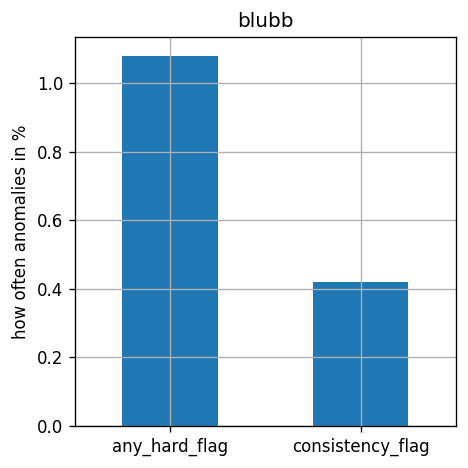

In [50]:
subset = finisher_rel  # oder nur male

rates_main = subset[["any_hard_flag", "consistency_flag"]].mean() * 100

ax = rates_main.plot(kind="bar", figsize=(4, 4))
ax.set_ylabel("how often anomalies in %")
ax.set_title("blubb")
plt.xticks(rotation=0)
plt.tight_layout()


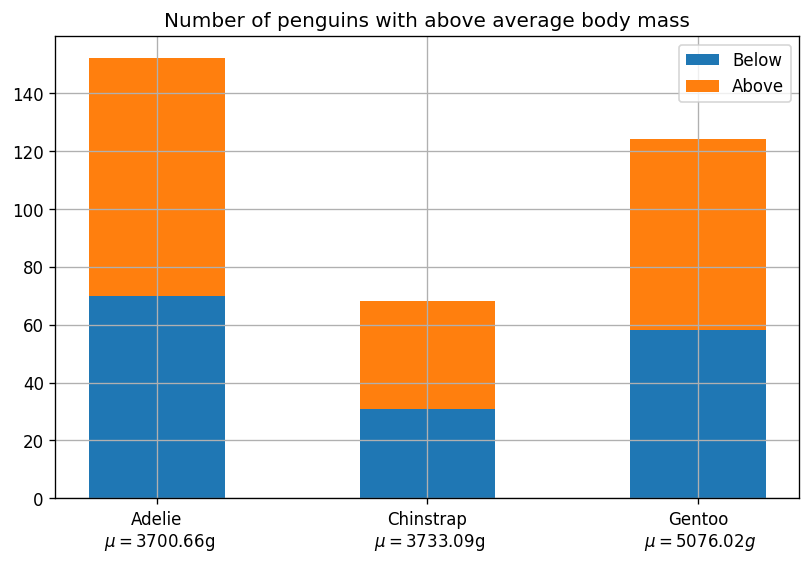

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "hard flags",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

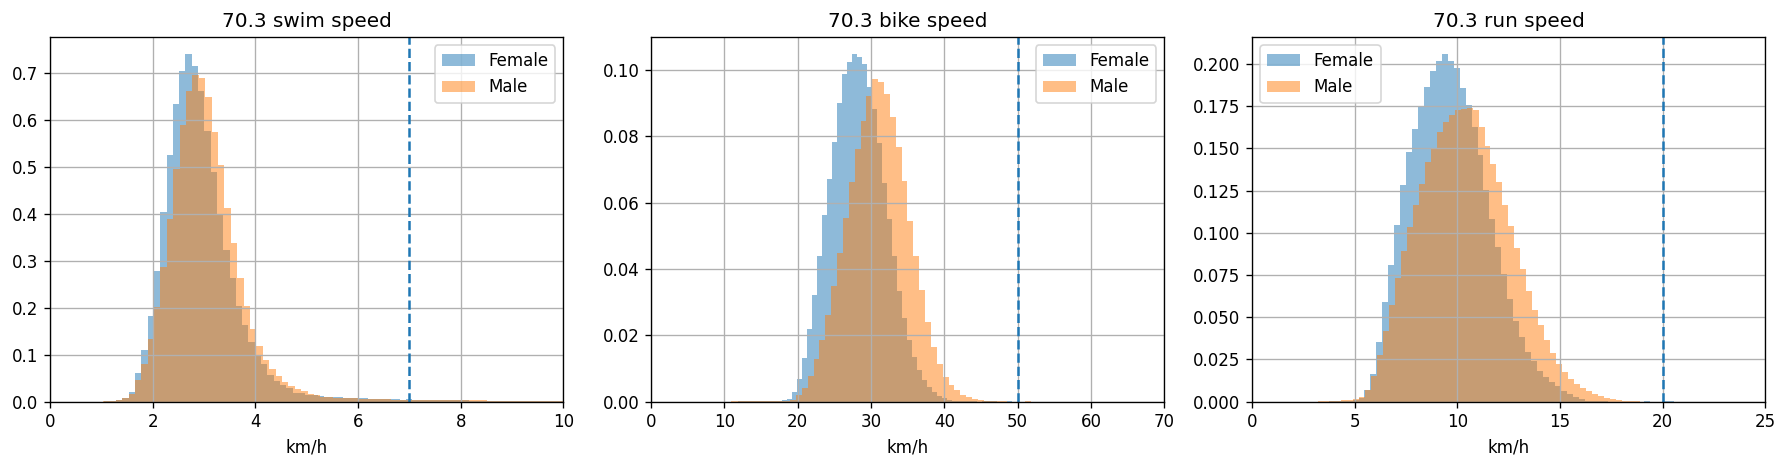

In [23]:
import numpy as np
import matplotlib.pyplot as plt

VISUAL_MAX = {
    "swim": 10.0,
    "bike": 70.0,
    "run":  25.0,
}

def plot_speed_dist(df, distance, leg, ax):
    col = f"{leg}_kmh"
    limit = {
        "swim": SWIM_LIMITS[distance],
        "bike": BIKE_LIMITS[distance],
        "run":  RUN_LIMITS[distance],
    }[leg]

    subset = df[(df["distance"] == distance) & (df["complete_sbr"])]

    for gender, g in subset.groupby("gender"):
        # clean up column for plotting
        vals = g[col].replace([np.inf, -np.inf], np.nan).dropna()
        # keep only values in a reasonable range
        vals = vals[vals <= VISUAL_MAX[leg]]

        ax.hist(vals, bins=80, alpha=0.5, density=True, label=gender)

    ax.axvline(limit, linestyle="--")
    ax.set_title(f"{distance} {leg} speed")
    ax.set_xlabel("km/h")
    ax.set_xlim(0, VISUAL_MAX[leg])
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, leg in zip(axes, ["swim", "bike", "run"]):
    plot_speed_dist(finisher_rel, "70.3", leg, ax)

plt.tight_layout()


In [24]:

summary = (
    finisher_rel
    .groupby("distance")[["swim_hard_flag","bike_hard_flag","run_hard_flag","overall_hard_flag","consistency_flag"]]
    .agg(["sum","mean"])
)
summary

swim_hard_flag           bike_hard_flag           run_hard_flag  \
                         sum      mean            sum      mean           sum   
distance                                                                        
70.3                   14605  0.008822            387  0.000234           638   
full-distance          10909  0.011444           2447  0.002567          1250   

                        overall_hard_flag           consistency_flag            
                   mean               sum      mean              sum      mean  
distance                                                                        
70.3           0.000385               193  0.000117             6055  0.003658  
full-distance  0.001311              1385  0.001453             4872  0.005111

In [44]:
finisher_rel.groupby(["race", "year"])[["swim_hard_flag", "bike_hard_flag", "run_hard_flag", "overall_hard_flag", "any_hard_flag", "consistency_flag"]].sum()

swim_hard_flag  bike_hard_flag  \
race                             year                                   
challengecopenhagen              2010               0               0   
                                 2011               0               0   
                                 2012               0               0   
ironman70.3aarhus                2014               0               0   
                                 2015              58               0   
...                                               ...             ...   
ironmanworldchampionship         2022               0               0   
                                 2023               0               0   
                                 2024               0               0   
                                 2025               0               0   
ironmanworldchampionshipstgeorge 2021               0               0   

                                       run_hard_flag  overall_hard_flag  \
race                             year                                     
challengecopenhagen              2010              0                  0   
                                 2011              0                  0   
                                 2012              0                  0   
ironman70.3aarhus                2014              1                  0   
                                 2015              0                  0   
...                                              ...                ...   
ironmanworldchampionship         2022              1                  0   
                                 2023              1                  0   
                                 2024              0                  0   
                                 2025              0                  0   
ironmanworldchampionshipstgeorge 2021              0                  0   

                                       any_hard_flag  consistency_flag  
race                             year                                   
challengecopenhagen              2010              0                 4  
                                 2011              0                 6  
                                 2012              0                19  
ironman70.3aarhus                2014              1                 6  
                                 2015             58                 4  
...                                              ...               ...  
ironmanworldchampionship         2022              1                30  
                                 2023              1                20  
                                 2024              0                13  
                                 2025              0                26  
ironmanworldchampionshipstgeorge 2021              0                 6  

[1770 rows x 6 columns]

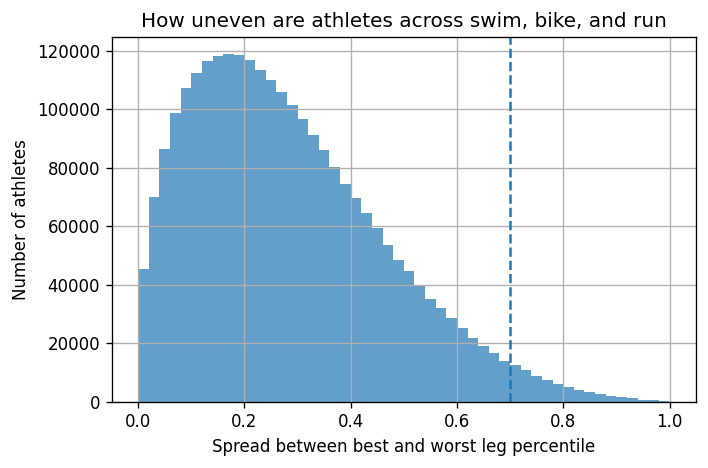

In [26]:
plt.figure(figsize=(6,4))
vals = finisher_rel["spread_rel"].dropna()
plt.hist(vals, bins=50, alpha=0.7)
plt.axvline(0.7, linestyle="--")  # whatever threshold you used
plt.xlabel("Spread between best and worst leg percentile")
plt.ylabel("Number of athletes")
plt.title("How uneven are athletes across swim, bike, and run")
plt.tight_layout()


## 8. Visualising flagged athletes <a id="examples"></a>

To make the flags more tangible, we look at individual athletes:

- A simple profile plot showing within-race percentiles for swim, bike, and run
- A small summary table with times, speeds, and percentiles

This helps to sanity-check whether the flagged cases are truly odd or just borderline.


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_athlete_profile(row, ref_lines=(0.5, 0.8)):
    """
    Plot a simple within-race percentile profile for one athlete.
    """
    legs = ["swim_rel", "bike_rel", "run_rel"]
    labels = ["Swim", "Bike", "Run"]
    vals = [row[l] for l in legs]

    y = np.arange(len(legs))

    fig, ax = plt.subplots(figsize=(4.5, 3))

    # horizontal bars
    ax.barh(y, vals, height=0.5)

    # reference lines (median, "elite" line, etc.)
    for x in ref_lines:
        ax.axvline(x, linestyle="--", linewidth=1, alpha=0.7)

    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_xlim(0, 1)

    ax.set_xlabel("Within-race percentile (0 = back, 1 = front)")
    title = f"{row['race']} {row['year']} – {row['Division']}"
    ax.set_title(title)

    plt.tight_layout()
    return fig, ax


(<Figure size 540x360 with 1 Axes>,
 <Axes: title={'center': 'ironman70.3arizona 2016 – F50-54'}, xlabel='Within-race percentile (0 = back, 1 = front)'>)

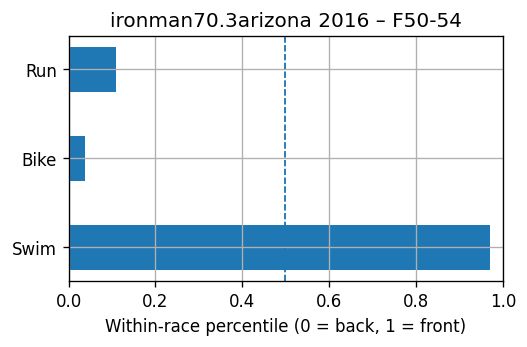

In [28]:
# e.g. one flagged athlete
example = finisher_rel[
    finisher_rel["consistency_flag"] | finisher_rel["any_hard_flag"]
].iloc[170]   # first one

# 170

### first sample is 100 | 110 | 170
# event_id for that race
race_id = example["event_id"]

# medians for that race only
race_medians = (
    finisher_rel[finisher_rel["event_id"] == race_id][["swim_rel","bike_rel","run_rel"]]
    .median()
)

plot_athlete_profile(example, race_medians)


In [29]:
import pandas as pd

def make_athlete_summary(row):
    """
    Build a small summary table for one athlete:
    Swim/Bike/Run time, speed, percentile.
    """
    data = {
        "Leg": ["Swim", "Bike", "Run"],
        "Time": [
            row["Swim Time"],
            row["Bike Time"],
            row["Run Time"],
        ],
        "Speed (km/h)": [
            row["swim_kmh"],
            row["bike_kmh"],
            row["run_kmh"],
        ],
        "Percentile (0–1)": [
            row["swim_rel"],
            row["bike_rel"],
            row["run_rel"],
        ],
    }
    return pd.DataFrame(data)


,Leg,Time,Speed (km/h),Percentile (0–1)
0,Swim,00:32:05,3.553247,0.970745
1,Bike,03:53:05,23.167680,0.037333
2,Run,03:13:23,6.546583,0.109043


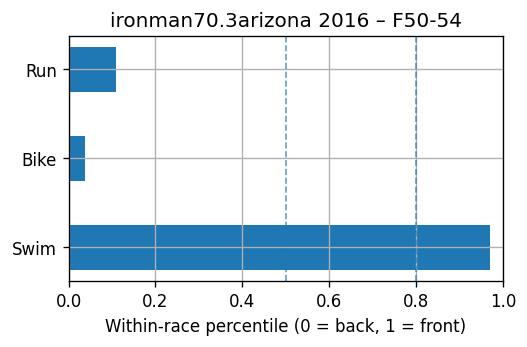

In [30]:
example = finisher_rel[
    finisher_rel["consistency_flag"] | finisher_rel["any_hard_flag"]
].iloc[170]

plot_athlete_profile(example)
make_athlete_summary(example)


,Leg,Time,Speed (km/h),Percentile (0–1)
0,Swim,00:13:40,8.341463,0.992620
1,Bike,03:00:10,29.972248,0.538603
2,Run,02:02:32,10.331882,0.268382


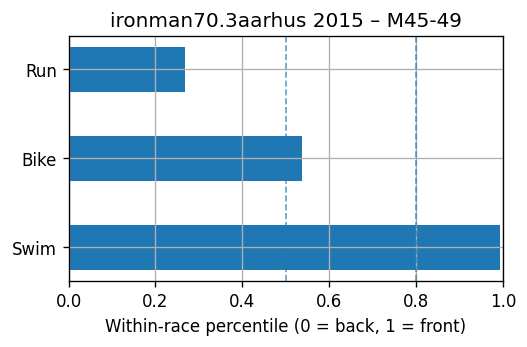

In [31]:
example = finisher_rel[
    finisher_rel["consistency_flag"] & finisher_rel["any_hard_flag"]
].iloc[1]

plot_athlete_profile(example)
make_athlete_summary(example)

C:\Users\JanBusse\AppData\Local\Temp\ipykernel_2220\161929119.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


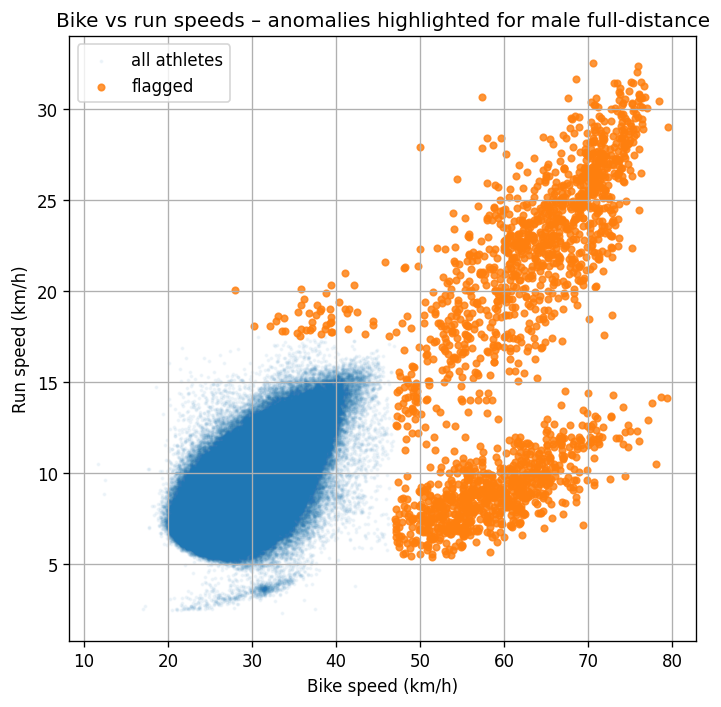

In [32]:
cols = ["bike_kmh", "run_kmh"]

core = finisher_rel.dropna(subset=cols).copy()


###finisher_rel.groupby("gender")[["swim_hard_flag", "bike_hard_flag", "run_hard_flag", "overall_hard_flag"]].sum()
# keep only plausible plotting range
core = core[(core["bike_kmh"] <= 80) & (core["run_kmh"] <= 35) & (core["distance"] == "full-distance") & (core["gender"] == "Male")]

suspects = core[core["bike_hard_flag"] | core["run_hard_flag"] & (core["distance"] == "full-distance") & (core["gender"] == "Male")].copy()


plt.figure(figsize=(6, 6))
plt.scatter(
    core["bike_kmh"], core["run_kmh"],
    s=2, alpha=0.05, label="all athletes"
)
plt.scatter(
    suspects["bike_kmh"], suspects["run_kmh"],
    s=15, alpha=0.8, label="flagged",
)
plt.xlabel("Bike speed (km/h)")
plt.ylabel("Run speed (km/h)")
plt.title("Bike vs run speeds – anomalies highlighted for male full-distance")
plt.legend()
plt.tight_layout()



In [33]:
### inspect a few cases in depths
cols = ["race","year","event_id","Division","gender",
        "Swim Time","Bike Time","Run Time",
        "swim_kmh","bike_kmh","run_kmh",
        "overall_rel","swim_rel","bike_rel","run_rel"]

finisher_rel.loc[finisher_rel["bike_hard_flag"], cols].head(10)

,race,year,event_id,Division,gender,Swim Time,Bike Time,Run Time,swim_kmh,bike_kmh,run_kmh,overall_rel,swim_rel,bike_rel,run_rel
351496,ironman70.3cartagena,2023,ironman70.3cartagena2023__2348,M35-39,Male,00:58:41,01:39:57,01:54:38,1.942630,54.027014,11.043908,0.975590,0.033415,0.999186,0.785598
408811,ironman70.3cozumel,2012,ironman70.3cozumel2012__534,MPRO,Male,00:24:22,01:33:15,01:42:51,4.678523,57.908847,12.309188,0.961872,0.990410,0.999128,0.950607
580776,ironman70.3florianopolis,2019,ironman70.3florianopolis2019__561,M35-39,Male,00:28:20,01:42:30,01:49:07,4.023529,52.682927,11.602261,0.992147,0.951670,0.999118,0.490300
589522,ironman70.3florida,2004,ironman70.3florida2004__1107,M40-44,Male,00:30:28,01:46:41,02:35:37,3.741794,50.617091,8.135375,0.843434,0.957431,0.999278,0.187004
654378,ironman70.3geelong,2017,ironman70.3geelong2017__673,M18-24,Male,00:41:42,01:46:56,02:51:09,2.733813,50.498753,7.397020,0.004132,0.212810,0.997930,0.004132
777596,ironman70.3japan,2014,ironman70.3japan2014__2007,M40-44,Male,00:39:53,01:22:35,03:12:19,2.858337,65.388496,6.582893,0.872695,0.807557,0.999121,0.035119
1102762,ironman70.3monterrey,2022,ironman70.3monterrey2022__2042,M40-44,Male,00:26:30,01:25:46,00:43:16,4.301887,62.961524,29.260401,0.996845,0.996840,0.996835,0.936909
1102763,ironman70.3monterrey,2022,ironman70.3monterrey2022__2042,M30-34,Male,00:28:43,01:22:59,00:37:37,3.969820,65.073308,33.655295,0.998423,0.988152,0.998418,0.993691
1102764,ironman70.3monterrey,2022,ironman70.3monterrey2022__2042,M50-54,Male,00:32:21,01:33:15,00:39:11,3.523957,57.908847,32.309655,0.977918,0.951027,0.947785,0.987382
1102765,ironman70.3monterrey,2022,ironman70.3monterrey2022__2042,M45-49,Male,00:29:55,01:33:47,00:38:37,3.810585,57.579527,32.783772,0.982650,0.977883,0.943038,0.992114


In [34]:
finisher_rel.loc[finisher_rel["any_hard_flag"], [
    "race", "year", "event_id", "Division", "gender",
    "Swim Time", "Bike Time", "Run Time",
    "swim_kmh", "bike_kmh", "run_kmh",
    "swim_hard_flag", "bike_hard_flag", "run_hard_flag",
]].tail(10)


,race,year,event_id,Division,gender,Swim Time,Bike Time,Run Time,swim_kmh,bike_kmh,run_kmh,swim_hard_flag,bike_hard_flag,run_hard_flag
3125968,ironmantexas,2016,ironmantexas2016__326,MPRO,Male,00:54:24,03:40:33,03:27:58,4.191176,48.968488,12.175028,False,True,False
3125970,ironmantexas,2016,ironmantexas2016__326,MPRO,Male,00:54:27,03:33:15,03:37:56,4.187328,50.644783,11.618232,False,True,False
3125975,ironmantexas,2016,ironmantexas2016__326,MPRO,Male,00:56:37,03:43:35,03:33:52,4.027083,48.304137,11.839152,False,True,False
3125977,ironmantexas,2016,ironmantexas2016__326,MPRO,Male,01:07:40,03:48:29,03:21:36,3.369458,47.268218,12.559524,False,True,False
3125983,ironmantexas,2016,ironmantexas2016__326,MPRO,Male,01:04:39,03:44:13,03:44:27,3.526682,48.167695,11.280909,False,True,False
3173067,ironmanuk,2022,ironmanuk2022__1877,M45-49,Male,00:36:24,08:08:57,04:23:58,6.263736,22.088148,9.592120,True,False,False
3244525,ironmanwesternaustralia,2023,ironmanwesternaustralia2023__2130,M35-39,Male,01:16:48,03:15:49,04:47:59,2.968750,55.153630,8.792175,False,True,False
3329184,ironmanworldchampionship,2017,ironmanworldchampionship2017__408,HC,NaN,00:53:14,05:25:17,02:19:20,4.283031,33.201824,18.172249,False,False,True
3336685,ironmanworldchampionship,2022,ironmanworldchampionship2022__1803,MHC,Male,01:03:01,05:01:23,02:05:58,3.618090,35.834762,20.100556,False,False,True
3343763,ironmanworldchampionship,2023,ironmanworldchampionship2023__2186,MHC,Male,01:01:07,06:25:38,02:06:12,3.730570,28.005878,20.063391,False,False,True


In [35]:


finisher_rel.loc[finisher_rel["consistency_flag"], [
    "race", "year", "event_id", "Division", "gender",
    "Swim Time", "Bike Time", "Run Time",
    "swim_kmh", "bike_kmh", "run_kmh",
    "swim_hard_flag", "bike_hard_flag", "run_hard_flag","consistency_flag"
]].head(100)


,race,year,event_id,Division,gender,Swim Time,Bike Time,Run Time,swim_kmh,bike_kmh,run_kmh,swim_hard_flag,bike_hard_flag,run_hard_flag,consistency_flag
91,challengecopenhagen,2010,challengecopenhagen2010__210,M25-29,Male,01:19:20,05:02:17,03:06:25,2.873950,35.728070,13.582477,False,False,False,True
168,challengecopenhagen,2010,challengecopenhagen2010__210,M30-34,Male,01:20:08,04:58:05,03:28:13,2.845258,36.231479,12.160410,False,False,False,True
470,challengecopenhagen,2010,challengecopenhagen2010__210,M30-34,Male,01:09:49,06:01:47,03:10:31,3.265696,29.852121,13.290176,False,False,False,True
926,challengecopenhagen,2010,challengecopenhagen2010__210,M18-24,Male,00:45:46,06:19:48,04:38:57,4.981792,28.436019,9.076896,False,False,False,True
1623,challengecopenhagen,2011,challengecopenhagen2011__211,F30-34,Female,01:22:17,05:15:14,03:35:48,2.770914,34.260336,11.733086,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39156,ironman70.3alagoas,2017,ironman70.3alagoas2017__1411,M35-39,Male,00:44:00,02:26:55,01:30:37,2.590909,36.755530,13.970940,False,False,False,True
39321,ironman70.3alagoas,2017,ironman70.3alagoas2017__1411,M30-34,Male,00:43:40,02:38:47,01:30:04,2.610687,34.008607,14.056255,False,False,False,True
39384,ironman70.3alagoas,2017,ironman70.3alagoas2017__1411,M35-39,Male,00:41:27,02:17:06,02:08:30,2.750302,39.387309,9.852140,False,False,False,True
39409,ironman70.3alagoas,2017,ironman70.3alagoas2017__1411,M35-39,Male,00:27:58,02:27:44,02:18:27,4.076281,36.552347,9.144095,False,False,False,True


## 9. Regression-based anomaly scores for the run leg <a id="regression-anomalies"></a>

Finally, we build a simple regression model to detect more subtle anomalies in the run leg.

Idea:
- Predict `run_rel` (run percentile) from other available features such as `swim_rel`, `bike_rel`, and `overall_rel`, plus division/age group
- Compute residuals: `run_resid = run_rel – run_pred`
- Standardise residuals to z-scores and flag athletes with very large positive or negative residuals

This is not about building a perfect predictor. The goal is to identify athletes whose run performance is very different from what their swim, bike, and overall performance would suggest.


In [36]:
### first, we build a model for male full-distance and then expand it to other races
df_reg = finisher_rel
mask = (
    (df_reg["distance"] == "full-distance") & 
    (df_reg["gender"] == "Male") & 
    (df_reg["any_hard_flag"] == 0)
)

df_sub = df_reg[mask].copy()

### one-hot encoding for divisions
df_sub = pd.get_dummies(df_sub, columns=["Division"], drop_first = True)

### now assign features
features = ["swim_rel", "bike_rel"] + [c for c in df_sub.columns if c.startswith("Division_")]
X= df_sub[features].values
y = df_sub["run_rel"].values

### basically press and play
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import OneHotEncoder

model_run = HuberRegressor().fit(X, y)

### now we predict and compute residuals
df_full_m = df_reg[(df_reg["distance"] == "full-distance") & (df_reg["gender"] == "Male")].copy()
df_full_m = pd.get_dummies(df_full_m, columns=["Division"], drop_first=True)

# Ensure the same feature columns exist
for col in features:
    if col not in df_full_m.columns:
        df_full_m[col] = 0.0

X_all = df_full_m[features].values
df_full_m["run_pred"] = model_run.predict(X_all)
df_full_m["run_resid"] = df_full_m["run_rel"] - df_full_m["run_pred"]

### standardise and flag

# standardise and flag
std = df_full_m["run_resid"].std()   # std of residuals
df_full_m["run_resid_z_score"] = df_full_m["run_resid"] / std
df_full_m["run_regression_flag"] = df_full_m["run_resid_z_score"].abs() > 3


c:\Users\JanBusse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [37]:
df_full_m["run_regression_flag"].mean()  # fraction of finishers flagged


np.float64(0.006106308340061244)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_run = HuberRegressor().fit(X_train, y_train)

y_pred_train = model_run.predict(X_train)
y_pred_test = model_run.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print("R² train:", r2_train)
print("R² test :", r2_test)
print("MAE test:", mean_absolute_error(y_test, y_pred_test))



c:\Users\JanBusse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


R² train: 0.5087521207276008
R² test : 0.5066324692255813
MAE test: 0.1577877338162787


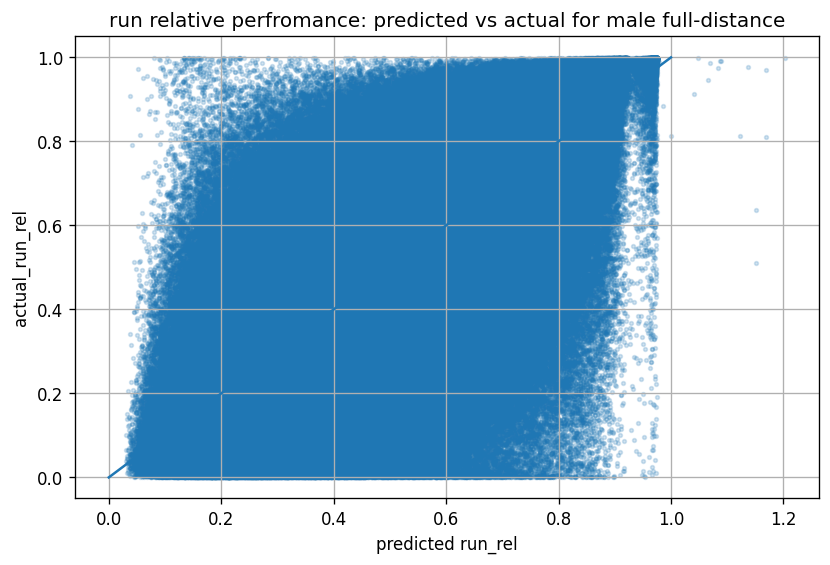

In [39]:
import matplotlib.pyplot as plt

plt.scatter(df_full_m["run_pred"], df_full_m["run_rel"], alpha=0.2, s=5)
plt.plot([0,1], [0,1])
plt.xlabel("predicted run_rel")
plt.ylabel("actual_run_rel")
plt.title("run relative perfromance: predicted vs actual for male full-distance")
plt.show()

C:\Users\JanBusse\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


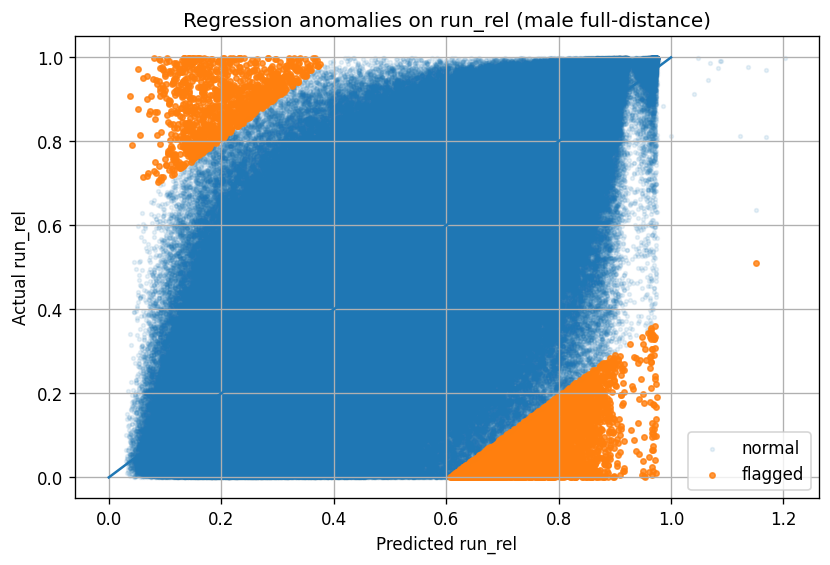

In [40]:
flagged = df_full_m["run_regression_flag"]

plt.scatter(df_full_m.loc[~flagged, "run_pred"],
            df_full_m.loc[~flagged, "run_rel"],
            alpha=0.1, s=5, label="normal")

plt.scatter(df_full_m.loc[flagged, "run_pred"],
            df_full_m.loc[flagged, "run_rel"],
            alpha=0.8, s=10, label="flagged")

plt.plot([0, 1], [0, 1])
plt.xlabel("Predicted run_rel")
plt.ylabel("Actual run_rel")
plt.legend()
plt.title("Regression anomalies on run_rel (male full-distance)")
plt.show()


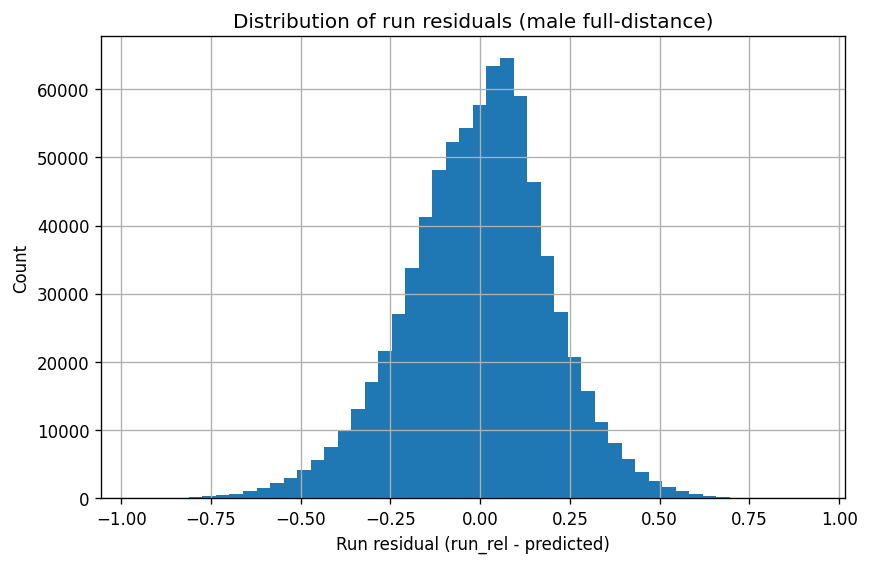

In [41]:
plt.hist(df_full_m["run_resid"], bins=50)
plt.xlabel("Run residual (run_rel - predicted)")
plt.ylabel("Count")
plt.title("Distribution of run residuals (male full-distance)")
plt.show()


In [42]:
top_anomalies = df_full_m.reindex(df_full_m["run_resid_z_score"].abs().sort_values(ascending=False).head(20).index)

cols_to_show = [
    "Overall Time", "swim_rel", "bike_rel", "run_rel","Swim Time", "Bike Time", "Run Time",
    "run_pred", "run_resid", "run_resid_z_score", "any_hard_flag", "consistency_flag"
]

###top_anomalies[cols_to_show]

top_anomalies_filtered = top_anomalies[(top_anomalies["run_regression_flag"] == True) & (top_anomalies["consistency_flag"] == True)]

top_anomalies_filtered[cols_to_show]


,Overall Time,swim_rel,bike_rel,run_rel,Swim Time,Bike Time,Run Time,run_pred,run_resid,run_resid_z_score,any_hard_flag,consistency_flag
3020550,12:06:48,0.993585,0.998574,0.011404,00:49:17,04:30:57,06:42:00,0.973712,-0.962308,-4.767028,False,True
2734243,12:36:24,0.990850,0.989556,0.005222,00:52:19,04:59:08,06:44:57,0.966995,-0.961773,-4.764380,False,True
2781960,13:05:11,0.959288,0.991725,0.014631,00:59:55,04:59:24,07:00:38,0.967476,-0.952844,-4.720148,False,True
3001838,14:05:39,0.980135,0.972858,0.001688,00:50:31,04:58:22,08:12:29,0.954360,-0.952672,-4.719293,False,True
2499631,13:58:39,0.971418,0.969675,0.003608,00:57:48,04:58:25,13:58:39,0.951715,-0.948108,-4.696683,False,True
2499587,08:48:04,0.986252,0.981509,0.012987,00:52:19,04:52:34,08:48:04,0.960926,-0.947939,-4.695846,False,True
2171838,12:41:21,0.972603,0.990037,0.024907,00:56:24,04:41:12,06:59:44,0.966706,-0.941799,-4.665432,False,True
2496944,09:32:05,0.995388,0.963048,0.006144,00:45:42,05:01:18,09:32:05,0.947696,-0.941551,-4.664203,False,True
2950431,13:06:25,0.967562,0.968156,0.014493,00:50:22,05:05:43,07:03:52,0.950465,-0.935972,-4.636567,False,True
3203397,12:33:02,0.989619,0.994810,0.042388,00:53:50,05:19:15,06:11:22,0.970809,-0.928421,-4.599161,False,True
